# Pruebas
---
reproducción mínimalista (no entrenamiento, solo carga)

Model loaded from modelParams


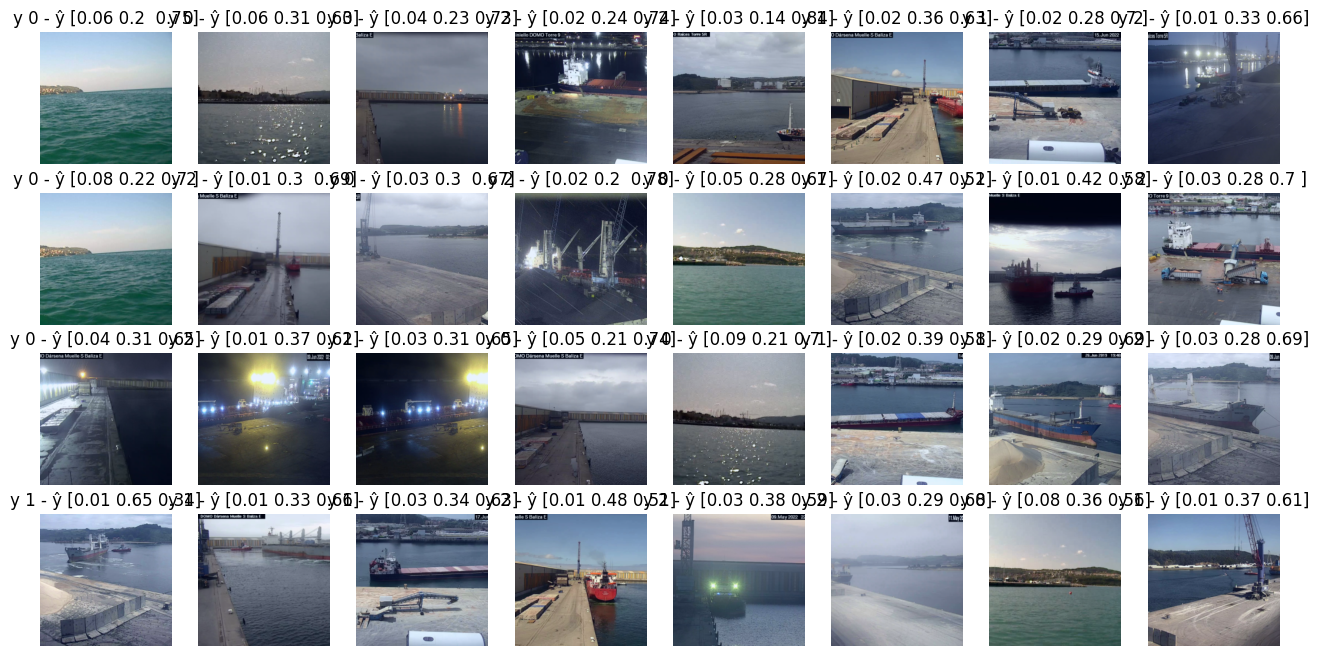

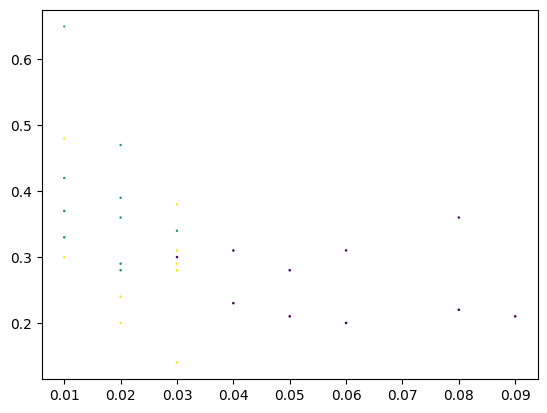

In [1]:
from torch.utils.data import DataLoader
from ship_classifier import ShipDataset, ShipClassifier, plotgrid

dataAugmentation = False
docked=True
pretrained=False

classifier = ShipClassifier(pretrained=pretrained,docked=docked)
classifier.load_model('modelParams')
classifier.model.to('mps')

trainset = ShipDataset(root_dir='/Users/pepe/carrera/3/2/vca/practicas/p2', 
                       train=True, 
                       dataAugmentation=dataAugmentation, 
                       docked=docked)
testset = ShipDataset(root_dir='/Users/pepe/carrera/3/2/vca/practicas/p2', 
                      train=False, 
                      dataAugmentation=False, 
                      docked=docked)

testloader = DataLoader(
        trainset, 
        batch_size=512, 
        num_workers=8)


testloader = DataLoader(
        testset, 
        batch_size=512, 
        num_workers=8)

plotgrid(classifier,trainset)

#test_acc, test_accuracies, f1, cm = classifier.test_model(trainloader)

[0.01925893 0.3103648  0.6703763 ]


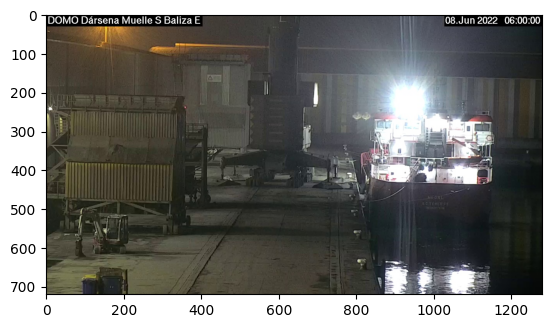

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

im = plt.imread('imagen.jpg')
plt.imshow(im)

classifier.model.to('mps')

im = torch.permute(torch.tensor(np.expand_dims(im,0),dtype=torch.float32),(0,3,1,2)).to('mps')

print(classifier.model(im)[0].cpu().detach().numpy())